In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
from mne.preprocessing import (create_eog_epochs, create_ecg_epochs,
                               compute_proj_ecg, compute_proj_eog)
import scipy.io
import scipy.interpolate
from scipy import signal
from matplotlib import patches
from IPython.display import HTML


plt.rcParams['figure.figsize'] = [10, 5]

In [35]:
import os
import numpy as np
import pandas as pd
from sklearn import cluster, datasets, metrics
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.datasets import make_blobs
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import mglearn
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.cluster import KMeans

In [ ]:
class EEG_File:
    """
    A class to import and store relevant eeg files

    Attributes
    ----------
    experiment : str
        experiment folder name within the data folder
    mat : list(int)
        a list of integers representing impact times
    raw : mne.io.Raw
        raw experiment data in FIF format
    """

    def __init__(self, experiment):
        self.experiment = experiment
        self.mat = scipy.io.loadmat("data/"+experiment+"/impact locations.mat")
        self.raw = mne.io.read_raw_eeglab("data/"+experiment+"/fixica.set")


class Epochs:
    """
    A class to represent epochs and underlying data

    Attributes
    ----------
    eeg_file : EEG_File
        eeg file data
    data : mne.Epochs
        the generated epoch data

    Methods
    -------
    generate_epochs(duration, start_second):
        Calculates epochs based on a duration and start second
    """

    def __init__(self, experiment, duration=2, start_second=None):
        self.eeg_file = EEG_File(experiment)
        self.data = self.generate_epochs(duration, start_second)

    def generate_epochs(self, duration, start_second):
        if start_second:
            start_time = start_second*2049
            stim_mock = [[start_time]]
            tmin = 0
            tmax = duration
        else:
            stim_mock = self.eeg_file.mat["elecmax1"]
            tmin = -0.3
            tmax = tmin + duration
            print(tmax)

        events = [[ts, 0, i+1] for i, ts in enumerate(stim_mock[0])]

        epochs = mne.Epochs(
            self.eeg_file.raw,
            events,
            tmin=tmin,
            tmax=tmax,
            preload=True,
            baseline=(0, 0)
        )

        return epochs


In [2]:
raw = mne.io.read_raw_eeglab('../../data/fixica.set')
# raw = mne.io.read_epochs_eeglab('../data/online_test.set')

Reading C:\Users\mgaro\UBC-MDS\Capstone\simpl_eeg_capstone\data\fixica.fdt


<ipython-input-2-bd7e32e41eaa>:1: RuntimeWarning: Data file name in EEG.data (109 whole fixed ica.fdt) is incorrect, the file name must have changed on disk, using the correct file name (fixica.fdt).
  raw = mne.io.read_raw_eeglab('../../data/fixica.set')


In [3]:
raw = raw.set_eeg_reference(projection=True)

Adding average EEG reference projection.
1 projection items deactivated


In [6]:
type(raw)

mne.io.eeglab.eeglab.RawEEGLAB

In [4]:
raw

<RawEEGLAB | fixica.fdt, 19 x 11175225 (5456.7 s), ~32 kB, data not loaded>

In [7]:
raw.times

array([0.00000000e+00, 4.88281250e-04, 9.76562500e-04, ...,
       5.45665137e+03, 5.45665186e+03, 5.45665234e+03])

In [5]:
raw_df = raw.to_data_frame()

In [22]:
#raw_df.set_index('time')

,Fp1,Fp2,F7,T3,T5,F3,C3,P3,Fz,Cz,Pz,F4,C4,P4,F8,T4,T6,O1,O2
time,,,,,,,,,,,,,,,,,,,
0,-1.309180,-17.504066,-0.934941,12.458370,3.110043,0.399445,-0.824427,8.192215,2.764535,-1.003163,4.253562,13.615928,3.193182,9.777016,2.023224,8.134605,15.983869,-3.551786,7.306483
0,-1.366664,-17.707190,-0.935696,12.504413,3.016100,0.431123,-0.944412,8.104908,2.741335,-1.053120,4.191818,13.737228,3.309192,9.774727,2.021176,8.193565,15.941096,-3.612502,7.278894
1,15.275132,-1.613967,25.944092,16.369394,19.123390,20.245935,27.153799,32.618656,4.682581,14.432489,20.894924,-2.061573,-16.849432,13.966457,14.188269,0.948726,35.616409,6.693176,16.724426
1,15.259221,-1.763359,25.982115,16.439892,19.149214,20.305655,27.087055,32.651844,4.582679,14.375604,20.861244,-2.067911,-16.759865,13.921695,14.239827,0.961342,35.574158,6.814420,16.962944
2,24.320646,21.294743,29.273348,36.190701,30.900623,21.696165,32.211964,43.833370,4.397994,24.987123,32.643608,-18.852341,-7.435656,24.248709,12.634859,0.314506,32.368336,19.638361,16.652056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5456650,-0.211792,10.697310,-14.531826,12.793026,-9.036341,-16.845898,-21.756701,-9.844389,-18.925793,-11.286021,-10.296985,-14.877690,-4.805411,-10.968634,-12.127897,-7.813345,-9.517270,-7.663065,-2.985892
5456651,0.161600,10.186489,-13.580552,6.596169,-9.434369,-16.212305,-18.521297,-8.370523,-18.869396,-10.713539,-7.271566,-11.472207,-4.956153,-8.000952,-8.690601,-5.604794,-5.389194,-8.054649,5.840395
5456651,-3.728542,3.934337,-14.654056,-4.194075,-7.884426,-12.769772,-15.568685,-4.896610,-16.460442,-9.753442,-5.234596,-9.115169,-3.668637,-10.375922,-14.358104,-7.003763,-5.554564,-2.668821,-2.436323


In [14]:
raw_df.shape

(11175225, 20)

In [17]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11175225 entries, 0 to 11175224
Data columns (total 20 columns):
 #   Column  Dtype  
---  ------  -----  
 0   time    int64  
 1   Fp1     float64
 2   Fp2     float64
 3   F7      float64
 4   T3      float64
 5   T5      float64
 6   F3      float64
 7   C3      float64
 8   P3      float64
 9   Fz      float64
 10  Cz      float64
 11  Pz      float64
 12  F4      float64
 13  C4      float64
 14  P4      float64
 15  F8      float64
 16  T4      float64
 17  T6      float64
 18  O1      float64
 19  O2      float64
dtypes: float64(19), int64(1)
memory usage: 1.7 GB


In [38]:
raw_50s = raw_df.loc[0:49, :]
raw_50s

NameError: name 'raw_df' is not defined

In [13]:
raw_50s.to_csv('50s_df.csv')

In [3]:
df = pd.read_csv("50s_df.csv")

In [40]:
df.head()

,Unnamed: 0,time,Fp1,Fp2,F7,T3,T5,F3,C3,P3,...,Cz,Pz,F4,C4,P4,F8,T4,T6,O1,O2
0,0,0,-1.309180,-17.504066,-0.934941,12.458370,3.110043,0.399445,-0.824427,8.192215,...,-1.003163,4.253562,13.615928,3.193182,9.777016,2.023224,8.134605,15.983869,-3.551786,7.306483
1,1,0,-1.366664,-17.707190,-0.935696,12.504413,3.016100,0.431123,-0.944412,8.104908,...,-1.053120,4.191818,13.737228,3.309192,9.774727,2.021176,8.193565,15.941096,-3.612502,7.278894
2,2,1,15.275132,-1.613967,25.944092,16.369394,19.123390,20.245935,27.153799,32.618656,...,14.432489,20.894924,-2.061573,-16.849432,13.966457,14.188269,0.948726,35.616409,6.693176,16.724426
3,3,1,15.259221,-1.763359,25.982115,16.439892,19.149214,20.305655,27.087055,32.651844,...,14.375604,20.861244,-2.067911,-16.759865,13.921695,14.239827,0.961342,35.574158,6.814420,16.962944
4,4,2,24.320646,21.294743,29.273348,36.190701,30.900623,21.696165,32.211964,43.833370,...,24.987123,32.643608,-18.852341,-7.435656,24.248709,12.634859,0.314506,32.368336,19.638361,16.652056


In [6]:
X = df.to_numpy()

In [7]:
X

array([[  0.        ,   0.        ,  -1.30918026, ...,  15.9838686 ,
         -3.55178571,   7.30648327],
       [  1.        ,   0.        ,  -1.36666441, ...,  15.94109631,
         -3.61250186,   7.27889395],
       [  2.        ,   1.        ,  15.27513218, ...,  35.6164093 ,
          6.69317579,  16.72442627],
       ...,
       [ 47.        ,  23.        ,  -4.48297501, ..., -12.659338  ,
          5.65323639, -19.19051743],
       [ 48.        ,  23.        ,  -4.48127031, ..., -19.84896278,
          2.73878431, -23.93832207],
       [ 49.        ,  24.        ,  -1.9635061 , ..., -29.44876671,
          2.46244574, -21.88931084]])

In [74]:
y = df['time']

In [9]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)

KMeans(n_clusters=4)

In [10]:
kmeans.predict(X)

array([0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3])

In [15]:
raw_predict = df.copy()
raw_predict["Cluster"] = kmeans.predict(df)
raw_predict.head(10)

,Unnamed: 0,time,Fp1,Fp2,F7,T3,T5,F3,C3,P3,...,Pz,F4,C4,P4,F8,T4,T6,O1,O2,Cluster
0,0,0,-1.309180,-17.504066,-0.934941,12.458370,3.110043,0.399445,-0.824427,8.192215,...,4.253562,13.615928,3.193182,9.777016,2.023224,8.134605,15.983869,-3.551786,7.306483,0
1,1,0,-1.366664,-17.707190,-0.935696,12.504413,3.016100,0.431123,-0.944412,8.104908,...,4.191818,13.737228,3.309192,9.774727,2.021176,8.193565,15.941096,-3.612502,7.278894,0
2,2,1,15.275132,-1.613967,25.944092,16.369394,19.123390,20.245935,27.153799,32.618656,...,20.894924,-2.061573,-16.849432,13.966457,14.188269,0.948726,35.616409,6.693176,16.724426,1
3,3,1,15.259221,-1.763359,25.982115,16.439892,19.149214,20.305655,27.087055,32.651844,...,20.861244,-2.067911,-16.759865,13.921695,14.239827,0.961342,35.574158,6.814420,16.962944,1
4,4,2,24.320646,21.294743,29.273348,36.190701,30.900623,21.696165,32.211964,43.833370,...,32.643608,-18.852341,-7.435656,24.248709,12.634859,0.314506,32.368336,19.638361,16.652056,1
5,5,2,22.717419,26.920095,21.833462,36.593826,29.401411,15.509204,28.121790,39.794384,...,31.835472,-18.637110,-3.800584,25.296244,9.113737,0.764496,24.823915,19.532164,15.722034,1
6,6,3,20.650766,24.334818,17.886337,35.529728,26.479586,15.377842,25.451302,34.067142,...,26.390074,-12.968081,-4.749114,21.081213,8.133389,-0.816326,11.208894,18.864342,14.262330,1
7,7,3,19.184807,21.385252,13.959271,27.860357,20.872931,12.091838,20.247690,25.614559,...,16.196674,-17.727404,-10.234982,10.326221,7.287931,-6.861799,-8.929190,15.989717,11.819912,2
8,8,4,15.510012,17.672382,7.462257,22.575148,11.209568,6.568398,8.499168,11.988610,...,4.970629,-24.360899,-18.911522,-4.027951,4.118809,-14.825701,-24.738237,10.975150,7.712838,2
9,9,4,16.229559,23.893751,9.673010,19.669207,7.639111,5.831559,8.244798,6.065959,...,3.760951,-26.391138,-21.119410,-4.775907,6.842110,-15.446356,-27.964468,7.857319,8.197652,2


In [16]:
kmeans.cluster_centers_

array([[ 24.61538462,  12.07692308,   3.0394466 ,  -2.1107825 ,
          4.94525981,  12.77510769,  -7.94074442,   7.07327406,
         -3.87609176,  -4.31786186,   1.12776699,   6.23528231,
         -5.49862156,  10.49564965,   1.4480102 ,  -5.15061503,
         -2.68420328,  -1.02539022, -12.21761173, -11.83035446,
        -12.87864872],
       [ 17.38461538,   8.46153846,  21.08483373,  22.44911452,
         20.606013  ,  17.26280392,  20.89117058,  17.10383291,
         29.99229358,  31.28949591,  10.72221606,  23.53903734,
         22.56770831,  -9.77439073,  -0.12800483,  16.29553028,
         11.26120457,   0.88578619,  16.86908999,   9.21233064,
          8.91600082],
       [ 15.        ,   7.23076923,  18.41830349,  23.25414779,
         13.44493763,  13.5584587 ,  10.74646994,   9.67788429,
         17.0616538 ,  14.73012308,   9.16191196,  12.70374467,
         10.12578315, -21.8293482 , -11.83655109,   2.69920658,
          7.54188039,  -9.50905351, -12.26091134,   5.4081

IndexError: boolean index did not match indexed array along dimension 0; dimension is 4 but corresponding boolean dimension is 3

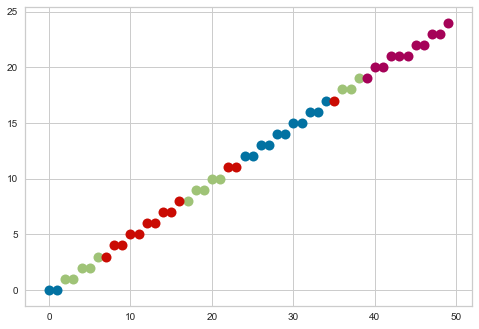

In [20]:
# From lecture, for testing
# mglearn.discrete_scatter(X[:, 0], X[:, 1], kmeans.labels_, markers="o")
# mglearn.discrete_scatter(
#     kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], [0, 1, 2], markers="*"
# );

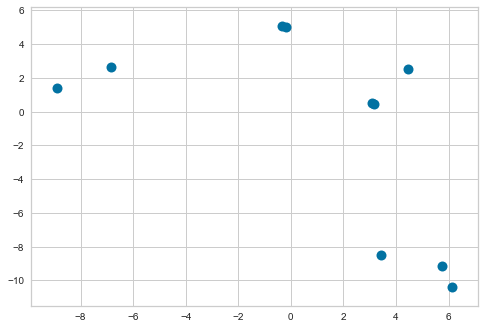

In [26]:
# From lecture, for testing
# X, y = make_blobs(n_samples=10, centers=4, n_features=19, random_state=10)
# mglearn.discrete_scatter(X[:, 0], X[:, 1], markers="o");

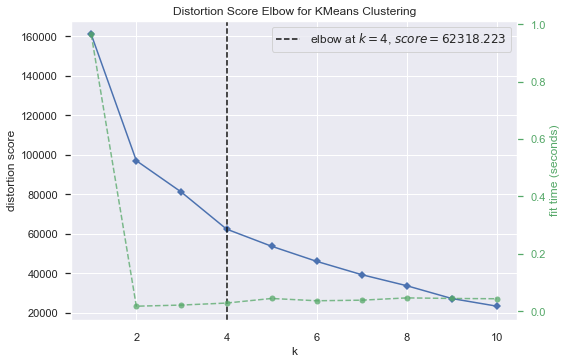

In [83]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 11))
visualizer.fit(X)  # Fit the data
visualizer.show();

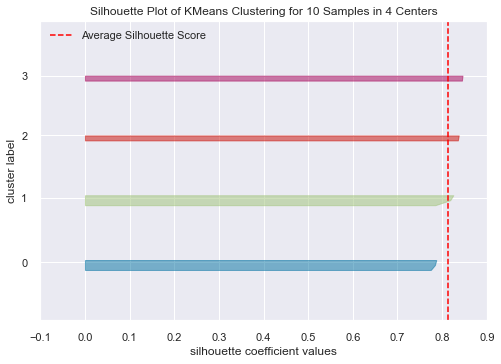

In [44]:
model2 = KMeans(4, random_state=42)
visualizer = SilhouetteVisualizer(model2, colors="yellowbrick")
visualizer.fit(X)  # Fit the data 
visualizer.show();

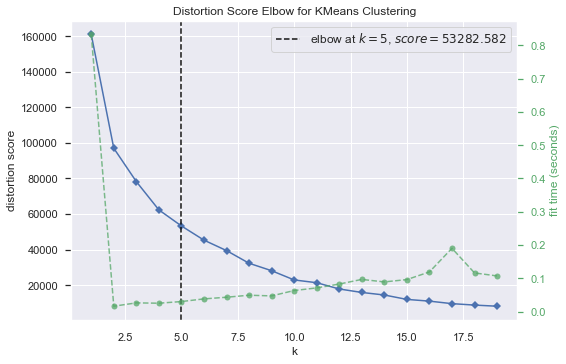

In [37]:
model3 = KMeans()
visualizer = KElbowVisualizer(model3, k=(1, 20))
visualizer.fit(df)  # Fit the data
visualizer.show();

In [80]:
kmeans.inertia_

62318.222603098606

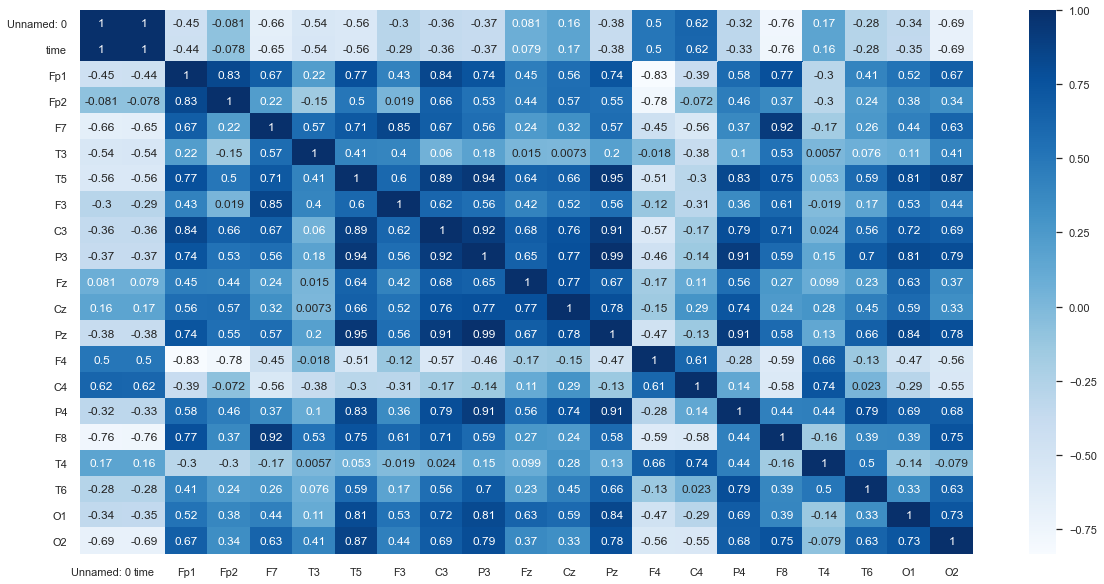

In [36]:
cor = df.corr()
plt.figure(figsize=(20, 10))
sns.set(font_scale=1)
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues);

In [98]:
pip install sklearn-som

In [100]:
from sklearn_som.som import SOM
from sompy.sompy import SOMFactory

ModuleNotFoundError: No module named 'sompy'

In [84]:
kmeans = KMeans(4)
kmeans.fit(df)
kmeans.cluster_centers_.shape

(4, 21)

In [85]:
# From lecture, for testing
from sklearn.decomposition import PCA

def plot_pca_clusters(data, labels):
    """
    Carries out dimensionality reduction on the data for visualization
    """
    pca = PCA(n_components=2)
    principal_comp = pca.fit_transform(data)
    pca_df = pd.DataFrame(
        data=principal_comp, columns=["pca1", "pca2"], index=data.index
    )
    pca_df["cluster"] = labels
    plt.figure(figsize=(6, 4))
    ax = sns.scatterplot(
        x="pca1", y="pca2", hue="cluster", data=pca_df, palette="tab10"
    )
    plt.show()

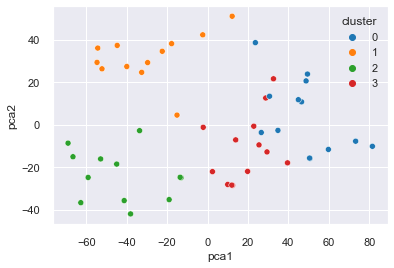

In [86]:
plot_pca_clusters(df, kmeans.labels_)

In [53]:
labels = kmeans.labels_
labels
# check how many of the samples were correctly labeled
correct_labels = sum(y == labels)
print("Result: %d out of %d samples were correctly labeled." % (correct_labels, y.size))

Result: 4 out of 50 samples were correctly labeled.


In [54]:
kmeans = KMeans(n_clusters=3,random_state=0)

kmeans.fit(X)

labels = kmeans.labels_

# check how many of the samples were correctly labeled

correct_labels = sum(y == labels)

print("Result: %d out of %d samples were correctly labeled." % (correct_labels, y.size))

print('Accuracy score: {0:0.2f}'. format(correct_labels/float(y.size)))


Result: 4 out of 50 samples were correctly labeled.
Accuracy score: 0.08


In [68]:
kmeans = KMeans(n_clusters=4,random_state=0)

kmeans.fit(X)

labels = kmeans.labels_

# check how many of the samples were correctly labeled

correct_labels = sum(y == labels)

print("Result: %d out of %d samples were correctly labeled." % (correct_labels, y.size))

print('Accuracy score: {0:0.2f}'. format(correct_labels/float(y.size)))


Result: 5 out of 50 samples were correctly labeled.
Accuracy score: 0.10


In [13]:
epoch = raw[0]

In [9]:
type(raw)

mne.io.eeglab.eeglab.RawEEGLAB

Effective window size : 1.000 (s)


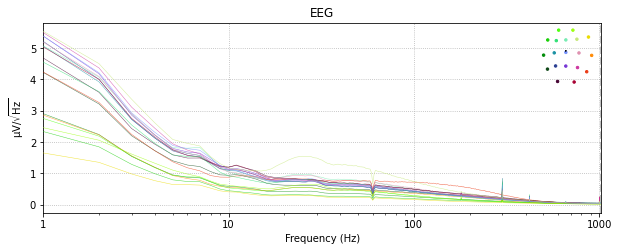

Effective window size : 1.000 (s)


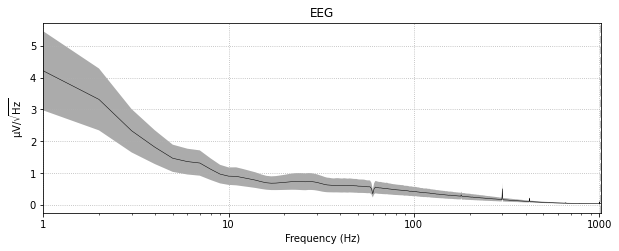

In [7]:
for average in (False, True):
    raw.plot_psd(average=average, dB=False, xscale='log')

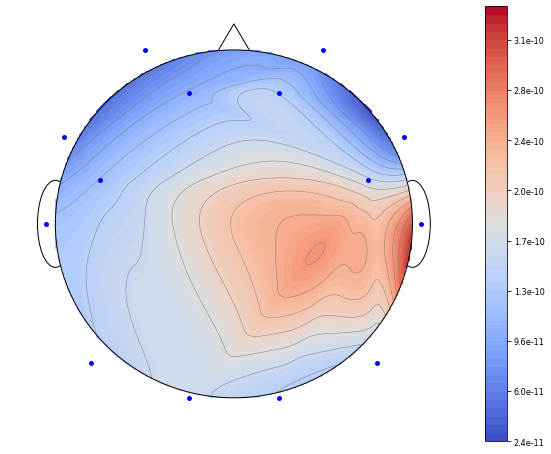

In [22]:
fig, ax = plt.subplots(figsize=(10,8))
plot_topomap(pwrs, ax, fig)
plt.show()
#fig.savefig("topograph.png", bbox_inches='tight')

-----------------------

## Plotting at periods of the data

(19, 30720)
(30720,)


/Users/mpin/opt/miniconda3/lib/python3.8/site-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


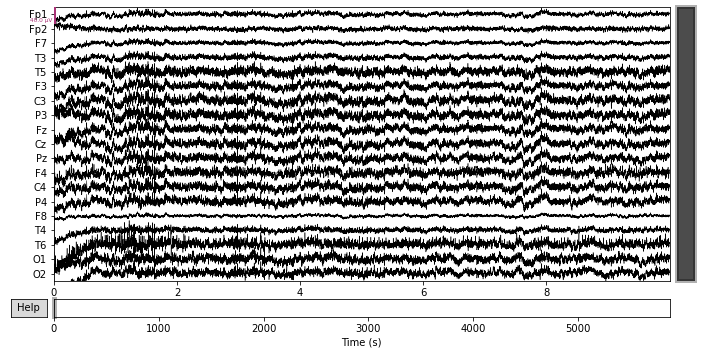

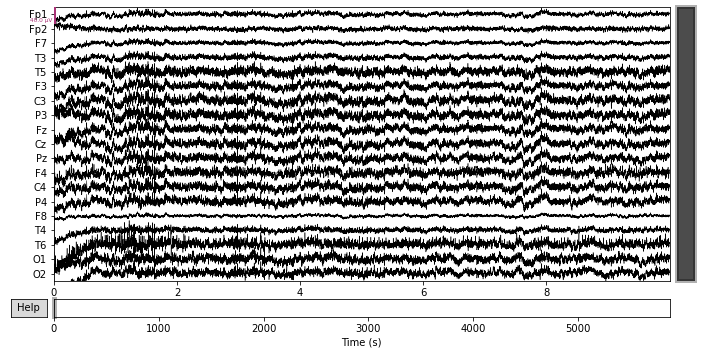

In [23]:
start, stop = raw.time_as_index([100, 115])  # 100 s to 115 s data segment
data, times = raw[:, start:stop]
print(data.shape)
print(times.shape)
data, times = raw[2:20:3, start:stop]  # access underlying data
raw.plot()

------------------------

## Creating events, epochs, and evoked data from mat file

In [4]:
mat = scipy.io.loadmat("../data/1122/impact locations.mat")
mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Mar 23 18:04:27 2021',
 '__version__': '1.0',
 '__globals__': [],
 'baselocs': array([[   24113, 11397293]], dtype=int32),
 'elecmax1': array([[ 1872728,  2226507,  2474660,  2735121,  2977559,  3386348,
          3941813,  4246698,  4488521,  4732498,  4994063,  5446315,
          5696726,  5943973,  6187127,  6455898,  7173445,  7383999,
          7630631,  7871373,  8101104,  8343280,  8580663,  8827988,
          9066266,  9314535,  9578138,  9901110, 10135164, 10384935,
         10633197, 10877445, 11132092]], dtype=int32)}

In [7]:
stim_mock = mat['elecmax1']

events = ([[stim_mock[0][0], 0, 1]])
for i in range(len(stim_mock[0])-1):
    events.append([stim_mock[0][i+1], 0, 1])

events = np.array(events)

print(events.shape)
events

(33, 3)


array([[ 1872728,        0,        1],
       [ 2226507,        0,        1],
       [ 2474660,        0,        1],
       [ 2735121,        0,        1],
       [ 2977559,        0,        1],
       [ 3386348,        0,        1],
       [ 3941813,        0,        1],
       [ 4246698,        0,        1],
       [ 4488521,        0,        1],
       [ 4732498,        0,        1],
       [ 4994063,        0,        1],
       [ 5446315,        0,        1],
       [ 5696726,        0,        1],
       [ 5943973,        0,        1],
       [ 6187127,        0,        1],
       [ 6455898,        0,        1],
       [ 7173445,        0,        1],
       [ 7383999,        0,        1],
       [ 7630631,        0,        1],
       [ 7871373,        0,        1],
       [ 8101104,        0,        1],
       [ 8343280,        0,        1],
       [ 8580663,        0,        1],
       [ 8827988,        0,        1],
       [ 9066266,        0,        1],
       [ 9314535,        

In [8]:
epochs = mne.Epochs(raw, events, tmin=-0.3, tmax=0.7) #tmin/tmax likely have to be adjusted
epochs

Not setting metadata
Not setting metadata
33 matching events found
Setting baseline interval to [-0.2998046875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated


Number of events,33
Events,1: 33
Time range,-0.300 – 0.700 sec
Baseline,-0.300 – 0.000 sec


In [9]:
event_dict = {'header': 1}

epochs = mne.Epochs(raw, events, tmin=-0.3, tmax=0.7, event_id=event_dict,
                    preload=True)

print(epochs.event_id)

Not setting metadata
Not setting metadata
33 matching events found
Setting baseline interval to [-0.2998046875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 33 events and 2049 original time points ...
0 bad epochs dropped
{'header': 1}


In [10]:
evoked = epochs['header'].average()
evoked

<Evoked | 'header' (average, N=33), -0.2998 – 0.7002 sec, baseline -0.299805 – 0 sec, 19 ch, ~334 kB>

-----------------

## Visualizing epochs

/Users/mpin/opt/miniconda3/lib/python3.8/site-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


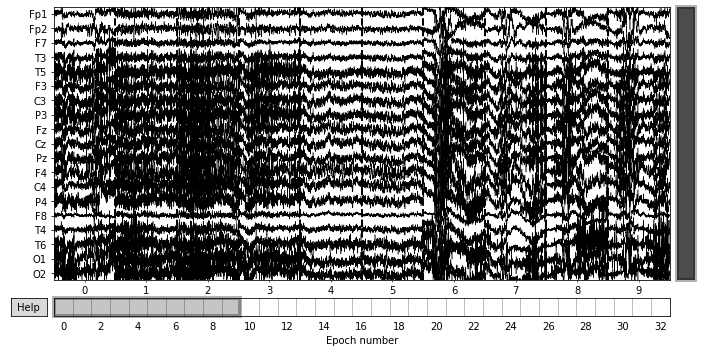

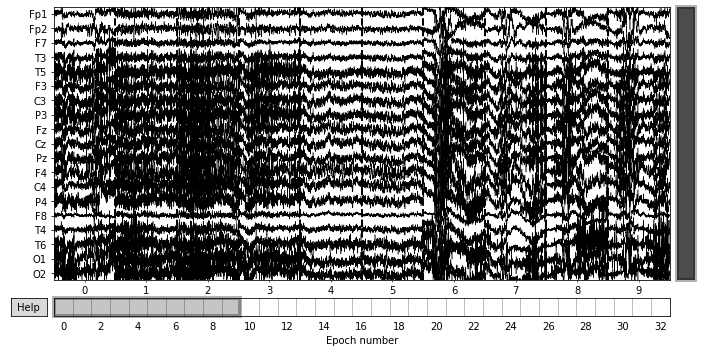

In [29]:
epochs.plot(n_epochs=10)

-----------